In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
pio.renderers.default = "png"

In [3]:
censusdata = pd.read_csv(
    r"c:\Users\chang\Downloads\ev_census_vehicle_data_fixed.csv")

C:\Users\chang\AppData\Local\Temp\ipykernel_18404\3734337657.py:1: DtypeWarning:

Columns (13,14,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
censusdata

,Unnamed: 0,STATION_NAME,CITY,STREET_ADDRESS,LATITUDE,LONGITUDE,EV_CONNECTOR_TYPES,EV_LEVEL1_EVSE_NUM,EV_LEVEL2_EVSE_CNUM,EV_DC_FAST_NUM,...,Year,Month,POPULATION,MEDIAN_INCOME,record_count,STATE_NAME,ELECTRIC_VEHICLE_REG_COUNT,PLUG_IN_HYBRID_VEHICLE_REG_COUNT,HYBRID_ELECTRIC_REG_COUNT,STATE
0,0,Anchorage Museum,Anchorage,625 C St,61.215712,-149.884840,"[""""J1772""""]",NaN,1.0,NaN,...,2023.0,7.0,289069.0,98152.0,1,Alaska,"2,700",900,"10,600",AK
1,1,Anchorage Point S,Anchorage,4647 Old Seward Hwy,61.177881,-149.867371,"[""""TESLA""""]",NaN,1.0,NaN,...,2023.0,6.0,289069.0,98152.0,1,Alaska,"2,700",900,"10,600",AK
2,2,EasyPark Susitna Parking Lot,Anchorage,898 W 5th Ave,61.217229,-149.898855,"[""""J1772""""]",NaN,1.0,NaN,...,2023.0,8.0,289069.0,98152.0,1,Alaska,"2,700",900,"10,600",AK
3,3,49th State Brewing Company - Tesla Destination,Anchorage,717 W 3rd Ave,61.219630,-149.895920,"[""""TESLA""""]",NaN,1.0,NaN,...,2024.0,7.0,289069.0,98152.0,1,NaN,NaN,NaN,NaN,NaN
4,4,Avis Anchorage,Anchorage,6607 Old Seward Hwy,61.160850,-149.863740,"[""""J1772""""]",NaN,4.0,NaN,...,2024.0,9.0,289069.0,98152.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,102618,VISTOR PARKING CLIFF HOUSE 3,York,591 Shore Road,43.220627,-70.579009,"[""""J1772""""]",NaN,2.0,NaN,...,2025.0,9.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
102619,102619,Stage Neck Inn - Tesla Destination,York Harbor,8 Stage Neck Rd,43.130686,-70.638748,"[""""TESLA""""]",NaN,2.0,NaN,...,2024.0,7.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
102620,102620,VT ELEC COOP VEC-JOHNSON 1,johnson,42 Wescom Rd,44.635607,-72.694127,"[""""J1772""""]",NaN,2.0,NaN,...,2025.0,9.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
102621,102621,Vachon Buick GMC,old saybrook,225 Middlesex ave,41.306276,-72.382028,"[""""J1772COMBO""""]",NaN,NaN,1.0,...,2025.0,9.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


In [5]:
censusdata['STATION_NAME'].count()

102622

In [6]:
df = censusdata.copy()

In [7]:
# Data Cleaning and Imputation for Setup

# Station Feature Pre-processing
charger = ['EV_LEVEL1_EVSE_NUM', 'EV_LEVEL2_EVSE_CNUM', 'EV_DC_FAST_NUM']
df[charger] = df[charger].fillna(0)
categorical_station = ['EV_PRICING', 'FACILITY_TYPE']
for col in categorical_station:
    df[col] = df[col].fillna('UNKNOWN')

In [8]:
#  Define Features and Preprocessing Pipeline for station clustering
numerical_station_features = charger  # L1, L2, DC counts
categorical_station_features = categorical_station  # Pricing, Facility Type

preprocessor_station = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_station_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_station_features)
    ],
    remainder='drop'  # Drop all other columns not used for station clustering
)

# Apply and standardlize data to station dataframe
X_station = df[numerical_station_features + categorical_station_features]
X_station_processed = preprocessor_station.fit_transform(X_station)
X_station_dense = X_station_processed.toarray()

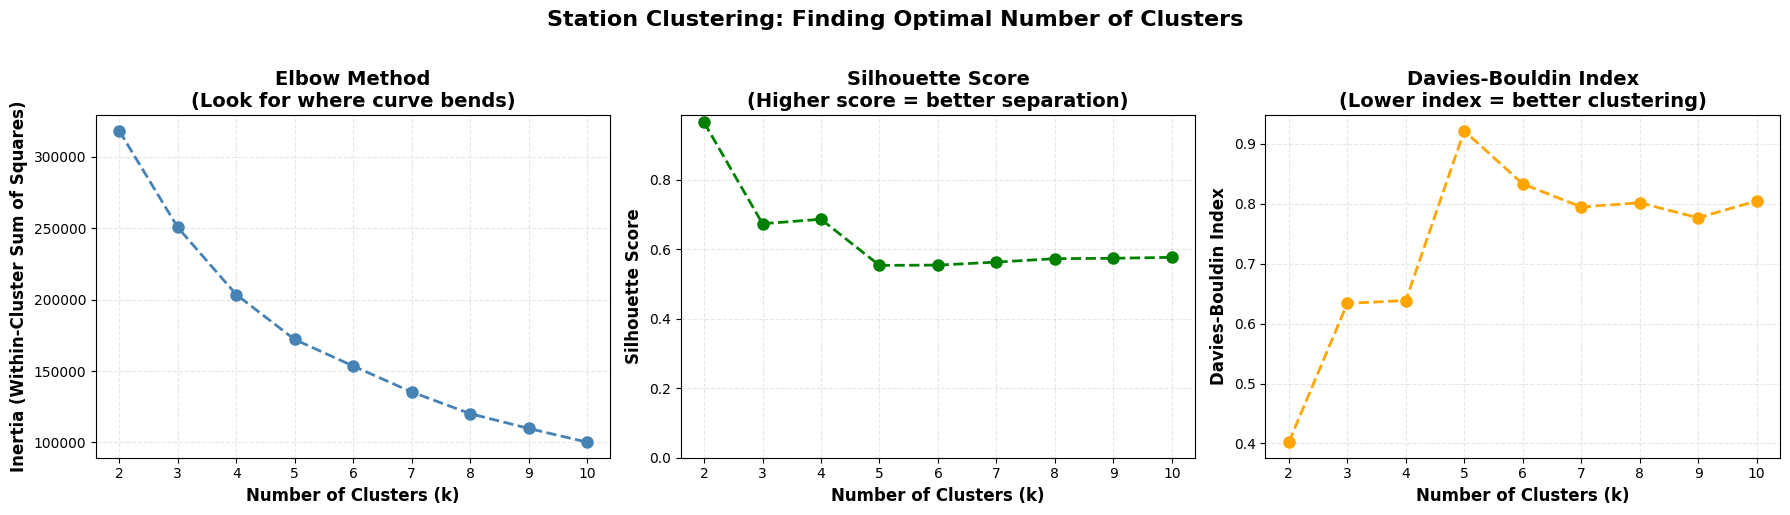

In [9]:
# Find the optimal kmeans clustering
# Store our results
inertia_scores = []
silhouette_scores = []
davies_bouldin_scores = []

k_values = range(2, 11)
# Test each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_station_dense)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_station_dense, cluster_labels))
    davies_bouldin_scores.append(
        davies_bouldin_score(X_station_dense, cluster_labels))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Elbow Method
ax1.plot(k_values, inertia_scores, 'o--', color='steelblue',
         linewidth=2, markersize=8, label='Inertia')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)',
               fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method\n(Look for where curve bends)',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(k_values)

# Plot 2: Silhouette Score
ax2.plot(k_values, silhouette_scores, 'o--', color='green',
         linewidth=2, markersize=8, label='Silhouette Score')

ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score\n(Higher score = better separation)',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(k_values)
ax2.set_ylim(bottom=0)

# Plot 3: Davies-Bouldin Index
ax3.plot(k_values, davies_bouldin_scores, 'o--', color='orange',
         linewidth=2, markersize=8, label='Davies-Bouldin Index')
ax3.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax3.set_title('Davies-Bouldin Index\n(Lower index = better clustering)',
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xticks(k_values)

# Add a main title
fig.suptitle('Station Clustering: Finding Optimal Number of Clusters',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [28]:
# Run station cluster
kmeans_station = KMeans(n_clusters=4)
station_cluster_labels = kmeans_station.fit_predict(X_station_dense)
X_station['Station_Cluster'] = pd.Series(
    station_cluster_labels, index=X_station.index)
X_station.groupby(['Station_Cluster']).mean().reset_index()

C:\Users\chang\AppData\Local\Temp\ipykernel_18404\4255744007.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Station_Cluster,EV_LEVEL1_EVSE_NUM,EV_LEVEL2_EVSE_CNUM,EV_DC_FAST_NUM,DBSCAN_Station_Cluster
0,0,0.020770,2.137488,0.292552,16.974460
1,1,0.004376,39.905908,0.385120,24.855580
2,2,36.235294,4.941176,0.000000,-1.000000
3,3,0.000000,0.090156,10.786151,26.659104


In [29]:
X_station

,EV_LEVEL1_EVSE_NUM,EV_LEVEL2_EVSE_CNUM,EV_DC_FAST_NUM,EV_PRICING,FACILITY_TYPE,Station_Cluster,Pricing_Category,DBSCAN_Station_Cluster
0,0.0,1.0,0.0,UNKNOWN,MUSEUM,0,Unknown,0
1,0.0,1.0,0.0,Free,OTHER,0,Free,1
2,0.0,1.0,0.0,UNKNOWN,PARKING_LOT,0,Unknown,2
3,0.0,1.0,0.0,Free,UNKNOWN,0,Free,3
4,0.0,4.0,0.0,UNKNOWN,FLEET_GARAGE,0,Unknown,4
...,...,...,...,...,...,...,...,...
102618,0.0,2.0,0.0,UNKNOWN,UNKNOWN,0,Unknown,6
102619,0.0,2.0,0.0,Free,UNKNOWN,0,Free,3
102620,0.0,2.0,0.0,UNKNOWN,UNKNOWN,0,Unknown,6
102621,0.0,0.0,1.0,UNKNOWN,UNKNOWN,0,Unknown,6


C:\Users\chang\AppData\Local\Temp\ipykernel_18404\3267929571.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



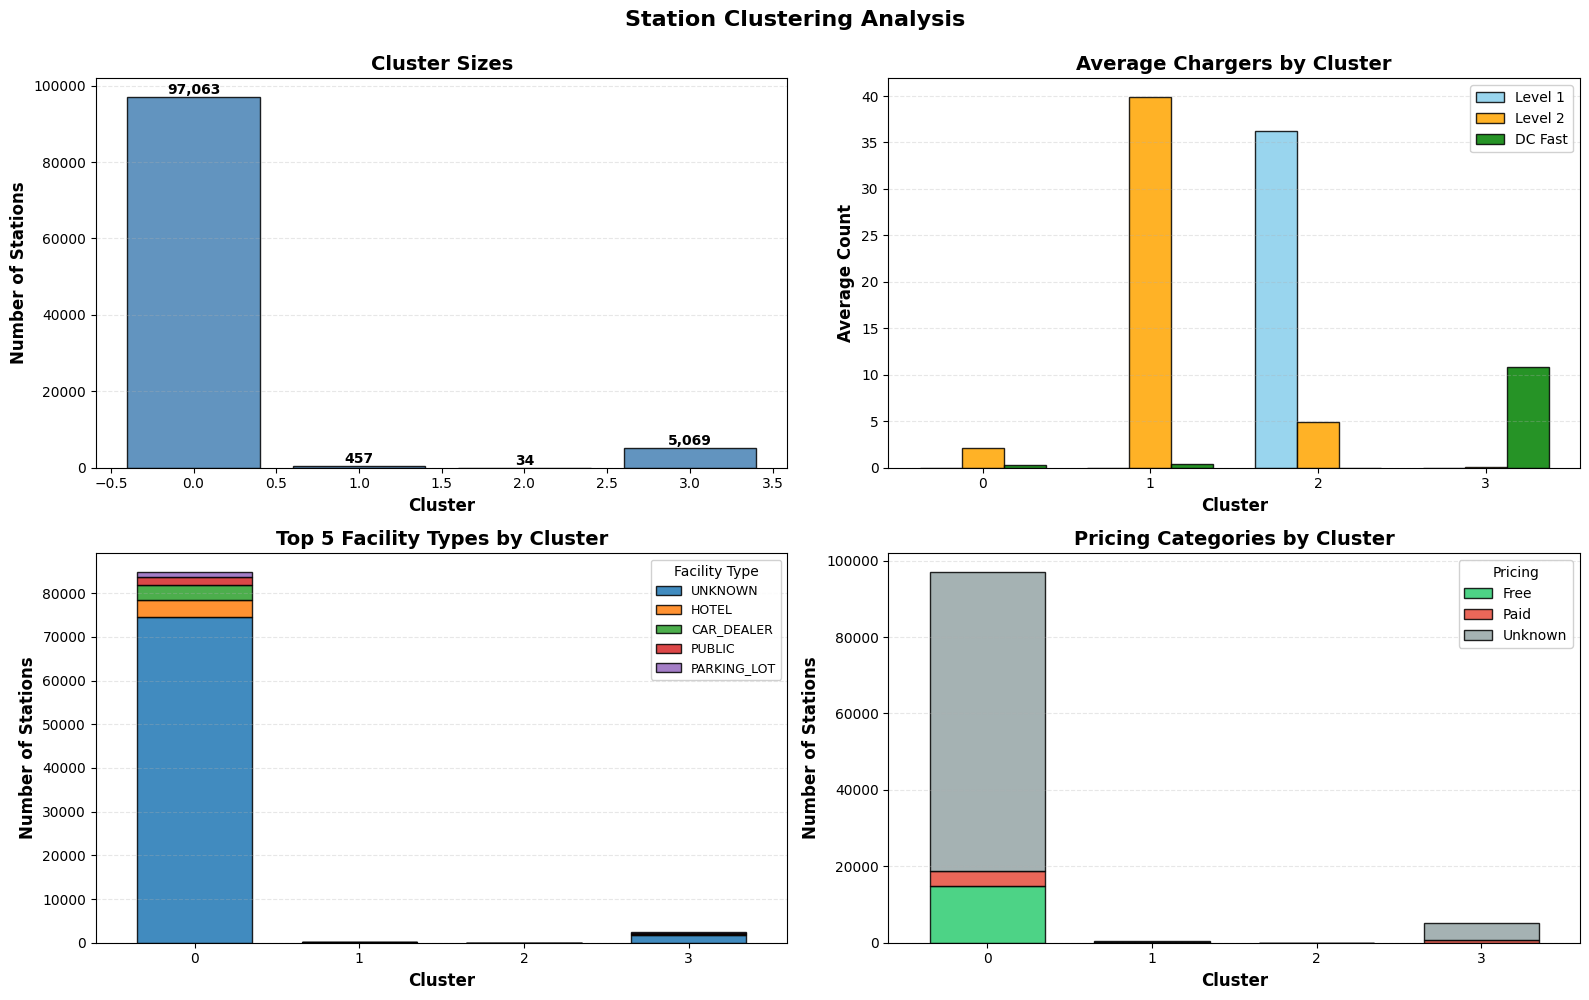

In [30]:
# Create 4 visualizations for station cluster
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Count stations per cluster
cluster_sizes = X_station['Station_Cluster'].value_counts().sort_index()

# Create bar chart
ax1.bar(cluster_sizes.index, cluster_sizes.values,
        color='steelblue', edgecolor='black', alpha=0.85)
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Stations', fontsize=12, fontweight='bold')
ax1.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels on top of bars
for i, count in enumerate(cluster_sizes.values):
    ax1.text(i, count, f'{count:,}', ha='center',
             va='bottom', fontsize=10, fontweight='bold')

# Calculate average chargers per cluster
avg_chargers = X_station.groupby('Station_Cluster')[
    ['EV_LEVEL1_EVSE_NUM', 'EV_LEVEL2_EVSE_CNUM', 'EV_DC_FAST_NUM']].mean()
cluster_positions = range(len(avg_chargers))
bar_width = 0.25

# Plot three bars for each cluster (Level 1, Level 2, DC Fast)
ax2.bar([pos - bar_width for pos in cluster_positions], avg_chargers['EV_LEVEL1_EVSE_NUM'],
        bar_width, label='Level 1', color='skyblue', edgecolor='black', alpha=0.85)
ax2.bar(cluster_positions, avg_chargers['EV_LEVEL2_EVSE_CNUM'], bar_width,
        label='Level 2', color='orange', edgecolor='black', alpha=0.85)
ax2.bar([pos + bar_width for pos in cluster_positions], avg_chargers['EV_DC_FAST_NUM'],
        bar_width, label='DC Fast', color='green', edgecolor='black', alpha=0.85)

ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Count', fontsize=12, fontweight='bold')
ax2.set_title('Average Chargers by Cluster', fontsize=14, fontweight='bold')
ax2.set_xticks(cluster_positions)
ax2.set_xticklabels(avg_chargers.index)
ax2.legend(fontsize=10, loc='best', framealpha=0.9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 5 most common facility types across all stations
top_5_facilities = X_station['FACILITY_TYPE'].value_counts().head(5).index

# Count how many of each facility type appear in each cluster
facility_counts_by_cluster = pd.crosstab(
    X_station['Station_Cluster'], X_station['FACILITY_TYPE'])

# Keep only the top 5 facility types
top_facilities_data = facility_counts_by_cluster[top_5_facilities]

top_facilities_data.plot(kind='bar', stacked=True,
                         ax=ax3, width=0.7, edgecolor='black', alpha=0.85)

ax3.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Stations', fontsize=12, fontweight='bold')
ax3.set_title('Top 5 Facility Types by Cluster',
              fontsize=14, fontweight='bold')
ax3.set_xticklabels(top_facilities_data.index, rotation=0)
ax3.legend(title='Facility Type', fontsize=9,
           loc='upper right', framealpha=0.9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Function to categorize pricing information


def categorize_pricing(price_info):
    """
    Classify charging station pricing as Free, Paid, or Unknown
    """
    price_str = str(price_info).lower()
    if 'free' in price_str:
        return 'Free'
    elif price_str in ['unknown', 'nan', '']:
        return 'Unknown'
    else:
        return 'Paid'


# Apply pricing categorization
X_station['Pricing_Category'] = X_station['EV_PRICING'].apply(
    categorize_pricing)

# Count pricing categories by cluster
pricing_by_cluster = pd.crosstab(
    X_station['Station_Cluster'], X_station['Pricing_Category'])

# Ensure all three categories exist in the right order
available_categories = [cat for cat in ['Free', 'Paid',
                                        'Unknown'] if cat in pricing_by_cluster.columns]
pricing_ordered = pricing_by_cluster[available_categories]
pricing_ordered.plot(kind='bar', stacked=True, ax=ax4, width=0.7, color=[
                     '#2ecc71', '#e74c3c', '#95a5a6'], edgecolor='black', alpha=0.85)
ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Stations', fontsize=12, fontweight='bold')
ax4.set_title('Pricing Categories by Cluster', fontsize=14, fontweight='bold')
ax4.set_xticklabels(pricing_ordered.index, rotation=0)
ax4.legend(title='Pricing', fontsize=10, loc='best', framealpha=0.9)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Add overall title
fig.suptitle('Station Clustering Analysis',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

In [31]:
# Data preprocessing and feature-engineering for regional clustering
regional_data = df.copy()
regional_data['POPULATION'] = regional_data['POPULATION'].fillna(
    regional_data['POPULATION'].mean())
regional_data['ELECTRIC_VEHICLE_REG_COUNT'] = pd.to_numeric(regional_data['ELECTRIC_VEHICLE_REG_COUNT'].astype(
    str).str.replace(r'[^\d.]', '', regex=True), errors='coerce').fillna(0)
regional_analysis = regional_data.groupby('STATE_NAME').agg(Population_Mean=('POPULATION', 'mean'), EV_Reg_Count_Sum=(
    'ELECTRIC_VEHICLE_REG_COUNT', 'sum'), Station_Count=('STATION_NAME', 'count')).reset_index()
regional_analysis['Adoption_Ratio'] = regional_analysis['EV_Reg_Count_Sum'] / \
    regional_analysis['Population_Mean']
regional_analysis['Infra_Balance_Ratio'] = regional_analysis['Station_Count'] / \
    regional_analysis['EV_Reg_Count_Sum']
regional_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
regional_analysis.dropna(
    subset=['Adoption_Ratio', 'Infra_Balance_Ratio'], inplace=True)
regional_clustering_features = ['Adoption_Ratio', 'Infra_Balance_Ratio']

# Standardlize feature for region dataframe
X_region = regional_analysis[regional_clustering_features]
scaler_region = StandardScaler()
X_region_scaled = scaler_region.fit_transform(X_region)

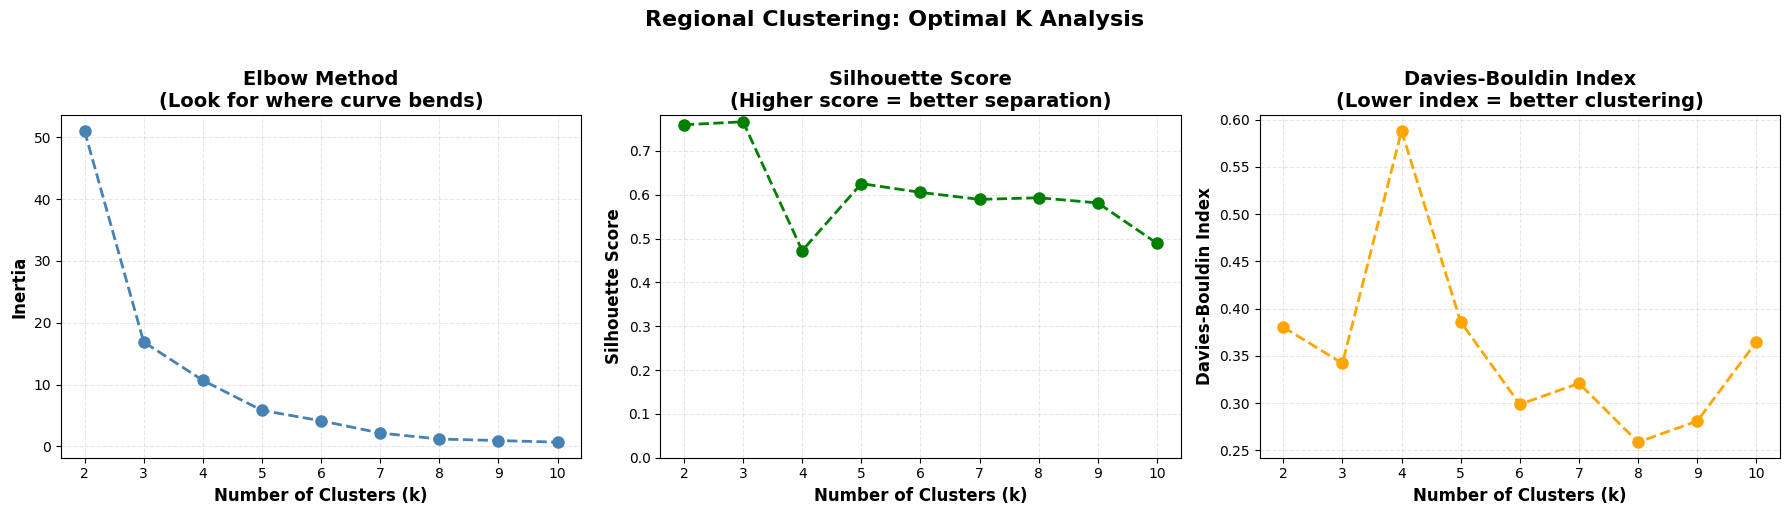

In [32]:
# Find the optimal kmeans clustering
# Store our results
inertia_scores = []
silhouette_scores = []
davies_bouldin_scores = []

# Test k from 2 to 10 clusters
k_values = range(2, 11)
# Test each k value
for k in k_values:
    # Fit KMeans on regional data
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_region_scaled)

    # Calculate the three evaluation metrics
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_region_scaled, cluster_labels))
    davies_bouldin_scores.append(
        davies_bouldin_score(X_region_scaled, cluster_labels))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Elbow Method
ax1.plot(k_values, inertia_scores, 'o--', color='steelblue',
         linewidth=2, markersize=8, label='Inertia')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method\n(Look for where curve bends)',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(k_values)

# Plot 2: Silhouette Score
ax2.plot(k_values, silhouette_scores, 'o--', color='green',
         linewidth=2, markersize=8, label='Silhouette Score')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score\n(Higher score = better separation)',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(k_values)
ax2.set_ylim(bottom=0)

# Plot 3: Davies-Bouldin Index
ax3.plot(k_values, davies_bouldin_scores, 'o--', color='orange',
         linewidth=2, markersize=8, label='Davies-Bouldin Index')
ax3.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax3.set_title('Davies-Bouldin Index\n(Lower index = better clustering)',
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xticks(k_values)

# Add overall title
fig.suptitle('Regional Clustering: Optimal K Analysis',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [67]:
# Run regional cluster
kmeans_region = KMeans(n_clusters=3)
region_cluster_labels = kmeans_region.fit_predict(X_region_scaled)
regional_analysis['Region_Cluster'] = pd.Series(
    region_cluster_labels, index=X_region.index)
regional_analysis.groupby(['Region_Cluster']).mean().reset_index()

,Region_Cluster,Population_Mean,EV_Reg_Count_Sum,Station_Count,Adoption_Ratio,Infra_Balance_Ratio,DBSCAN_Region_Cluster
0,0,4.726060e+05,5.269208e+06,67.051282,9.302506,0.000081,0.076923
1,1,1.923320e+06,3.386071e+08,389.500000,148.997260,0.000006,-1.000000
2,2,7.483139e+04,5.700000e+03,4.666667,0.109316,0.000832,-1.000000


In [68]:
regional_analysis

,STATE_NAME,Population_Mean,EV_Reg_Count_Sum,Station_Count,Adoption_Ratio,Infra_Balance_Ratio,Region_Cluster,STATE_CODE,Cluster_Label,DBSCAN_Region_Cluster
0,Alabama,1.469221e+05,156100.0,13,1.062468,8.327995e-05,0,AL,Moderate Need,0
1,Alaska,1.225446e+05,27000.0,10,0.220328,3.703704e-04,0,AK,Moderate Need,-1
2,Arizona,2.219177e+06,8626200.0,99,3.887117,1.147666e-05,0,AZ,Moderate Need,0
3,Arkansas,1.334294e+05,87600.0,16,0.656527,1.826484e-04,0,AR,Moderate Need,0
4,California,3.687234e+06,658165900.0,549,178.498542,8.341362e-07,1,CA,Critical Shortfall,-1
5,Colorado,3.878020e+05,12242300.0,142,31.568427,1.159913e-05,0,CO,Moderate Need,1
6,Delaware,3.134178e+05,55200.0,8,0.176123,1.449275e-04,0,DE,Moderate Need,0
7,District of Columbia,6.720790e+05,157700.0,23,0.234645,1.458465e-04,0,DC,Moderate Need,0
8,Florida,1.012052e+06,29475700.0,122,29.124684,4.139003e-06,0,FL,Moderate Need,1
9,Georgia,2.737307e+05,11347200.0,127,41.453881,1.119219e-05,0,GA,Moderate Need,1


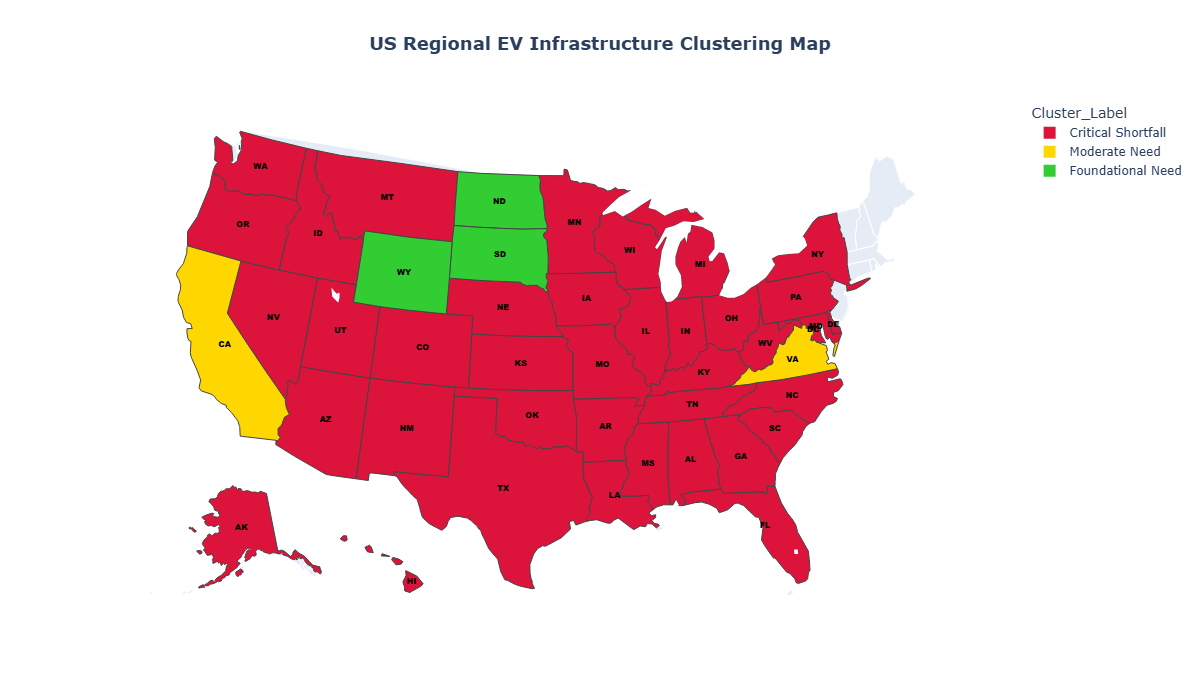

In [69]:
# Create a USA map visualization
# State abbreviations mapping
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Add state codes
regional_analysis['STATE_CODE'] = regional_analysis['STATE_NAME'].map(
    state_abbrev)

# Automatically detect clusters and create labels
unique_clusters = sorted(regional_analysis['Region_Cluster'].unique())

# Create cluster labels
regional_analysis['Cluster_Label'] = regional_analysis['Region_Cluster'].apply(
    lambda x: f'Cluster {x}')
cluster_names = {0: 'Critical Shortfall',
                 1: 'Moderate Need', 2: 'Foundational Need'}
cluster_colors_map = {0: '#DC143C',   1: '#FFD700',   2: '#32CD32'}

# Create cluster labels with meaningful names
regional_analysis['Cluster_Label'] = regional_analysis['Region_Cluster'].map(
    cluster_names)

# Create color mapping using the names
cluster_colors = {}
for cluster_id in unique_clusters:
    name = cluster_names[cluster_id]
    color = cluster_colors_map[cluster_id]
    cluster_colors[name] = color

# Create map
fig = px.choropleth(regional_analysis, locations='STATE_CODE', locationmode='USA-states', color='Cluster_Label', hover_name='STATE_NAME', color_discrete_map=cluster_colors, category_orders={'Cluster_Label': [f'Cluster {c}' for c in unique_clusters]}, scope='usa',
                    title='<b>US Regional EV Infrastructure Clustering Map</b>')

# Add text annotations for each state
for idx, row in regional_analysis.iterrows():
    fig.add_scattergeo(locations=[row['STATE_CODE']], locationmode='USA-states', text=row['STATE_CODE'], mode='text', showlegend=False, textfont=dict(size=8, color='black', family='Arial Black')
                       )

fig.update_layout(
    title_x=0.5,
    title_font_size=18,
    height=700,
    width=1200
)

fig.show()

In [70]:
# Add state_name to X_station to merge with the regional data using cross-tabulation
stations_state = X_station.copy()
stations_state['STATE_NAME'] = df['STATE_NAME']

# Now merge with regional cluster information
stations_region = stations_state.merge(
    regional_analysis[['STATE_NAME', 'Region_Cluster']], on='STATE_NAME', how='left')

# Create cross-tabulation
crosstab = pd.crosstab(stations_region['Station_Cluster'],
                       stations_region['Region_Cluster'], margins=True, margins_name='Total')

In [71]:
crosstab

Region_Cluster,0.0,1.0,2.0,Total
Station_Cluster,,,,
0,2577,740,14,3331
1,11,35,0,46
2,6,1,0,7
3,21,3,0,24
Total,2615,779,14,3408


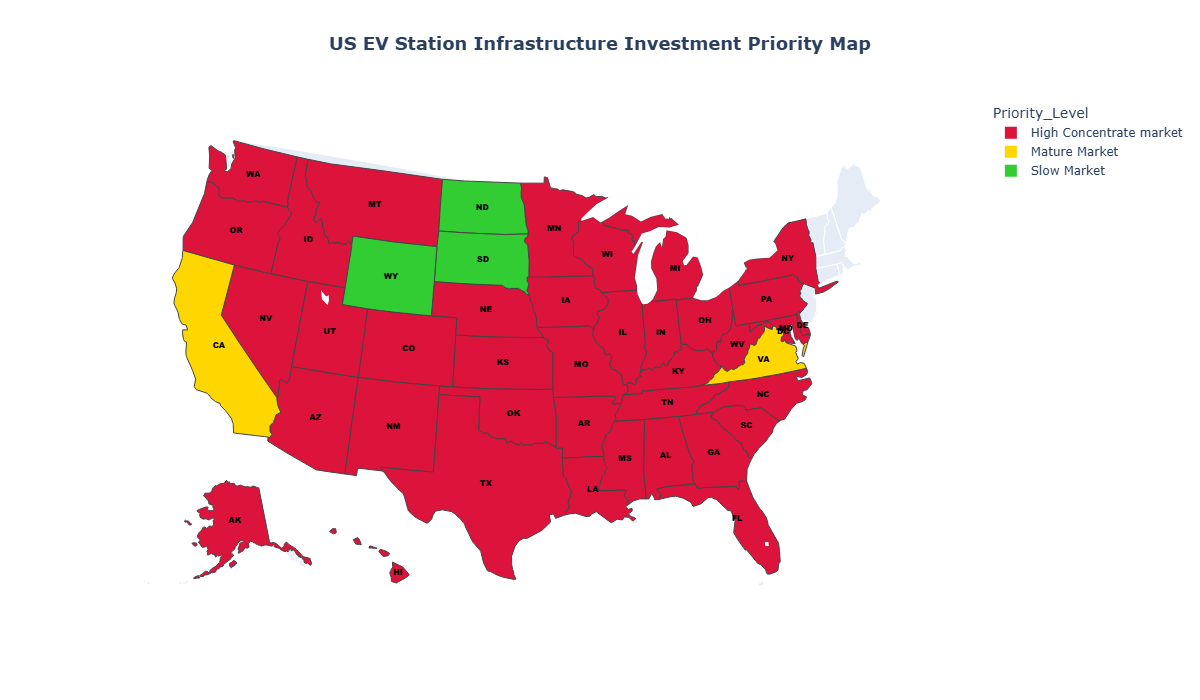

In [72]:
# Prepare state-level summary for mapping
state_map_data = stations_region.groupby('STATE_NAME').agg({'Station_Cluster': lambda x: x.mode()[
    0] if len(x.mode()) > 0 else x.iloc[0], 'Region_Cluster': 'first'}).reset_index()
state_map_data.columns = ['STATE_NAME',
                          'Dominant_Station_Cluster', 'Region_Cluster']

# Merge with state codes and metrics
state_map_data = state_map_data.merge(regional_analysis[[
                                      'STATE_NAME', 'STATE_CODE', 'Station_Count', 'Adoption_Ratio', 'Infra_Balance_Ratio']], on='STATE_NAME', how='left')

# Apply custom cluster names
cluster_names = {0: 'High Concentrate market',
                 1: 'Mature Market', 2: 'Slow Market'}
state_map_data['Priority_Level'] = state_map_data['Region_Cluster'].map(
    cluster_names)

# Define custom colors
cluster_colors = {'High Concentrate market': '#DC143C',
                  'Mature Market': '#FFD700', 'Slow Market': '#32CD32'}

fig = px.choropleth(state_map_data, locations='STATE_CODE', locationmode='USA-states', color='Priority_Level', hover_name='STATE_NAME',
                    hover_data={
                        'STATE_CODE': False,
                        'Region_Cluster': True,
                        'Dominant_Station_Cluster': True,
                        'Station_Count': ':,.0f',
                        'Adoption_Ratio': ':.6f',
                        'Infra_Balance_Ratio': ':.6f'
                    },
                    color_discrete_map=cluster_colors,
                    category_orders={'Priority_Level': [
                        'Critical Shortfall', 'Moderate Need', 'Foundational Need']},
                    scope='usa',
                    title='<b>US EV Station Infrastructure Investment Priority Map'
                    )

# Add state abbreviations
for idx, row in state_map_data.iterrows():
    fig.add_scattergeo(
        locations=[row['STATE_CODE']],
        locationmode='USA-states',
        text=row['STATE_CODE'],
        mode='text',
        showlegend=False,
        textfont=dict(size=8, color='black', family='Arial Black')
    )

fig.update_layout(
    title_x=0.5,
    title_font_size=18,
    height=700,
    width=1200
)

fig.show()

In [63]:
# Station cluster with DBSCAN
# Parameters tuned for the station data:
dbscan_station = DBSCAN(eps=1, min_samples=5, metric='euclidean')
station_labels_dbscan = dbscan_station.fit_predict(X_station_dense)
X_station['DBSCAN_Station_Cluster'] = station_labels_dbscan
num_clusters_station = len(set(station_labels_dbscan)) - \
    (1 if -1 in station_labels_dbscan else 0)
noise_points_station = list(station_labels_dbscan).count(-1)

C:\Users\chang\AppData\Local\Temp\ipykernel_18404\1169978416.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



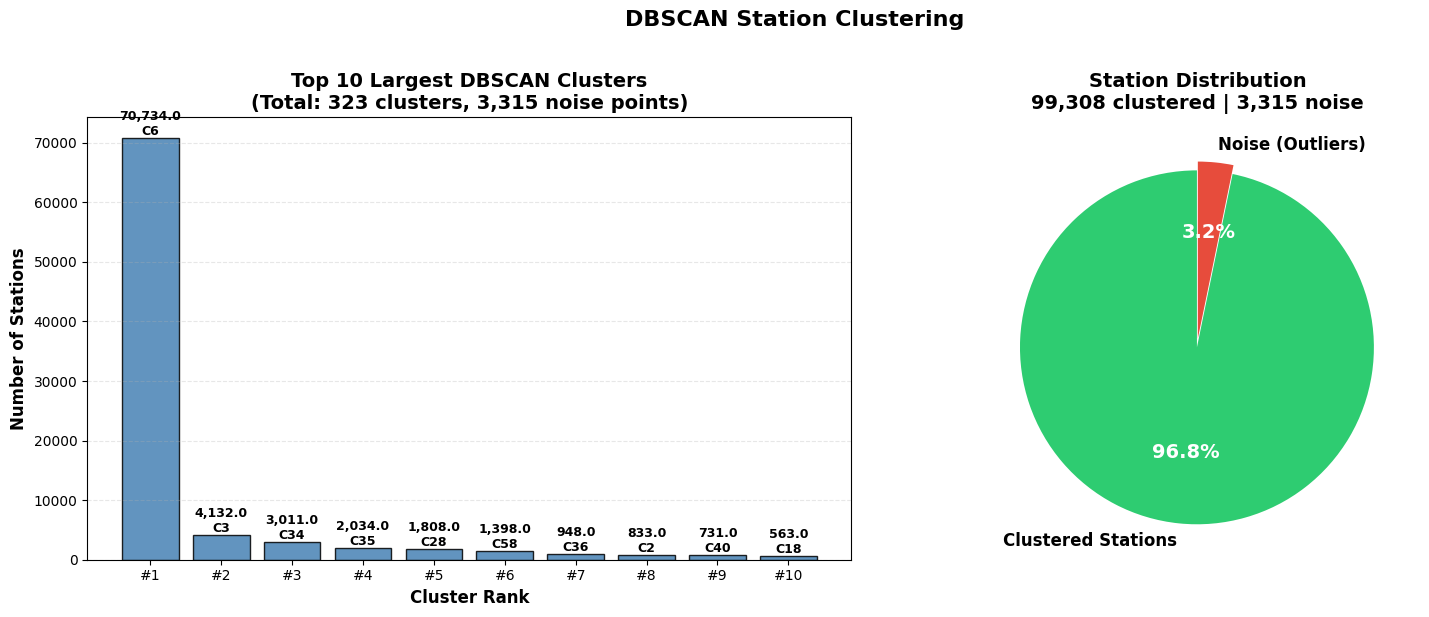

In [ ]:
# Prepare cluster statistics
cluster_stats = X_station.groupby('DBSCAN_Station_Cluster').agg(
    {'EV_LEVEL1_EVSE_NUM': 'mean', 'EV_LEVEL2_EVSE_CNUM': 'mean', 'EV_DC_FAST_NUM': 'mean'}).reset_index()
cluster_stats['Count'] = X_station.groupby(
    'DBSCAN_Station_Cluster').size().values
cluster_stats.columns = ['Cluster', 'Avg_Level1',
                         'Avg_Level2', 'Avg_DC_Fast', 'Count']

# Get top 10 clusters (excluding noise)
top_10_clusters = cluster_stats[cluster_stats['Cluster']
                                != -1].sort_values('Count', ascending=False).head(10)

# Calculate noise vs clustered
noise_count = (X_station['DBSCAN_Station_Cluster'] == -1).sum()
clustered_count = (X_station['DBSCAN_Station_Cluster'] != -1).sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Top 10 Cluster Sizes
ax1.bar(range(len(top_10_clusters)),
        top_10_clusters['Count'], color='steelblue', edgecolor='black', alpha=0.85)
ax1.set_xlabel('Cluster Rank', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Stations', fontsize=12, fontweight='bold')
ax1.set_title(
    f'Top 10 Largest DBSCAN Clusters\n(Total: {num_clusters_station} clusters, {noise_points_station:,} noise points)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(top_10_clusters)))
ax1.set_xticklabels([f'#{i+1}' for i in range(len(top_10_clusters))])
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels with cluster IDs
for i, (idx, row) in enumerate(top_10_clusters.iterrows()):
    ax1.text(i, row['Count'], f"{row['Count']:,}\nC{int(row['Cluster'])}",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)

wedges, texts, autotexts = ax2.pie(
    [clustered_count, noise_count],
    labels=['Clustered Stations', 'Noise (Outliers)'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Make percentage text more visible
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

ax2.set_title(
    f'Station Distribution\n{clustered_count:,} clustered | {noise_count:,} noise', fontsize=14, fontweight='bold')

plt.suptitle(f'DBSCAN Station Clustering',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [65]:
# Regional Clustering with DBSCAN
# Parameters tuned for the regional data:
dbscan_region = DBSCAN(eps=0.3, min_samples=3, metric='euclidean')
region_labels_dbscan = dbscan_region.fit_predict(X_region_scaled)
regional_analysis['DBSCAN_Region_Cluster'] = region_labels_dbscan
num_clusters_region = len(set(region_labels_dbscan)) - \
    (1 if -1 in region_labels_dbscan else 0)
noise_points_region = list(region_labels_dbscan).count(-1)

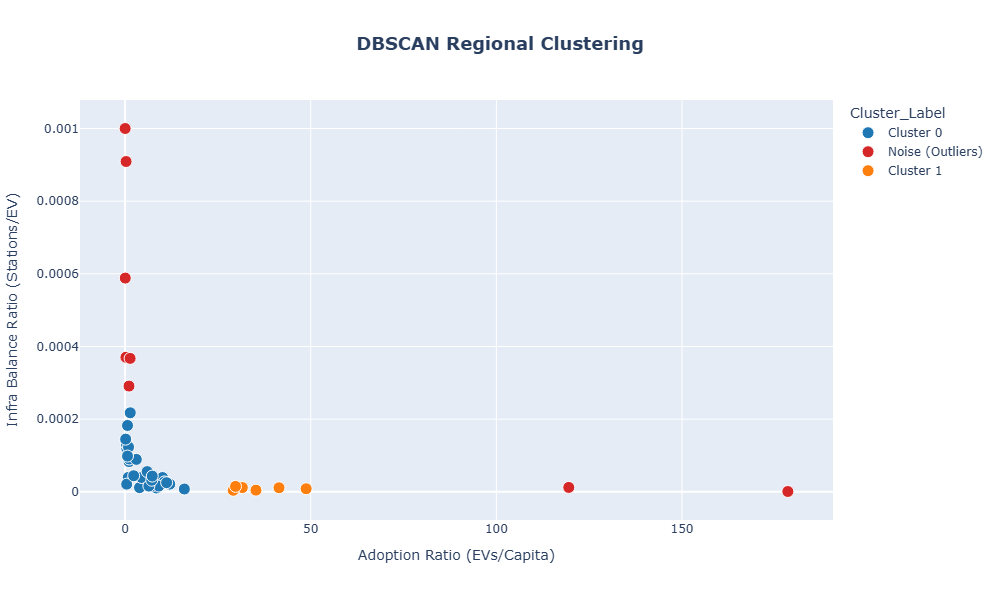

In [24]:
# Prepare regional data
regional_analysis['Cluster_Label'] = regional_analysis['DBSCAN_Region_Cluster'].apply(
    lambda x: 'Noise (Outliers)' if x == -1 else f'Cluster {x}')
color_map = {'Cluster 0': '#1f77b4',
             'Cluster 1': '#ff7f0e',  'Noise (Outliers)': '#d62728'}

# Create regional scatter plot
fig_regional = px.scatter(regional_analysis, x='Adoption_Ratio', y='Infra_Balance_Ratio', color='Cluster_Label', hover_name='STATE_NAME',
                          hover_data={
                              'Adoption_Ratio': ':.6f',
                              'Infra_Balance_Ratio': ':.6f',
                              'Station_Count': ':,.0f',
                              'Cluster_Label': True,
                              'DBSCAN_Region_Cluster': True
                          },
                          color_discrete_map=color_map,
                          title='<b>DBSCAN Regional Clustering',
                          labels={
                              'Adoption_Ratio': 'Adoption Ratio (EVs/Capita)',
                              'Infra_Balance_Ratio': 'Infra Balance Ratio (Stations/EV)'
                          }
                          )

fig_regional.update_traces(marker=dict(
    size=12, line=dict(width=1, color='white')))
fig_regional.update_layout(
    height=600,
    width=1000,
    title_x=0.5,
    title_font_size=18,
    hovermode='closest'
)

fig_regional.show()